In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# better display of review text in dataframes
pd.set_option('display.max_colwidth', None) 

# Seaborn options
sns.set(style="whitegrid", font_scale=1.4)

%load_ext autoreload
%autoreload 2

# Load data

## Dataset

In [2]:
import pickle

PICKLE_PATH = "allocine_dataset/data/allocine_dataset.pickle"

with open(PICKLE_PATH, 'rb') as reader:
    data = pickle.load(reader)

X_train, y_train = np.array(data["train_set"]['review']), np.array(data["train_set"]['polarity'])
X_val, y_val = np.array(data["val_set"]['review']), np.array(data["val_set"]['polarity'])
X_test, y_test = np.array(data["test_set"]['review']), np.array(data["test_set"]['polarity'])
class_names = data['class_names']

print("LEN TRAIN: "+ str(len(X_train)))
print("LEN VAL: "+ str(len(X_val)))
print("LEN TEST: "+ str(len(X_test)))

LEN TRAIN: 160000
LEN VAL: 20000
LEN TEST: 20000


# Model selection

## First model

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

tfidf_clf = Pipeline([
    ('tfidf', TfidfVectorizer()), # Default parameters
    ('clf', LogisticRegression(n_jobs=-1, verbose=1)),
])

tfidf_clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.2s finished


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling

## Prediction

In [5]:
some_index = 0
some_review = X_val[some_index]
print(some_review)
print()
print("True Polarity:", class_names[y_val[some_index]])

Ce film est tout ce qu'il y a de plus sympa. Même si l'ensemble n'est pas dépourvu de clichés, il serait hypocrite de dire que ce film est ennuyeux à regarder, bien au contraire. Il est très plaisant à regarder et même si l'ensemble est asse convenue, la mise en scène de Peter Chelsom est légère et ce film est une sorte de bouffée d'air frais. Tout à fait estimable.

True Polarity: Negative


In [6]:
some_prediction = tfidf_clf.predict([some_review, ])
print("Predicted Polarity:", class_names[some_prediction[0]]) # Good prediction !

Predicted Polarity: Negative


In [7]:
from sklearn import metrics

# Predicting training dataset
y_pred = tfidf_clf.predict(X_train)
print("Training Accuracy:", metrics.accuracy_score(y_train, y_pred))

# Predicting with a test dataset

y_pred = tfidf_clf.predict(X_val)
print("Validation Accuracy:", metrics.accuracy_score(y_val, y_pred))
print()
print(metrics.classification_report(y_val, y_pred, target_names=class_names.values()))

Training Accuracy: 0.9415375
Validation Accuracy: 0.9246

              precision    recall  f1-score   support

    Negative       0.93      0.92      0.93     10204
    Positive       0.92      0.93      0.92      9796

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



## Grid Search

In [7]:
from sklearn.model_selection import PredefinedSplit

# Grid-search on validation set.
X = np.concatenate((X_train, X_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)
validation_indexes = [-1]*len(X_train) + [0]*len(X_val)
ps = PredefinedSplit(test_fold=validation_indexes)

In [8]:
from sklearn.model_selection import GridSearchCV

param_grid = {
     'tfidf__lowercase': (True, False),
     'tfidf__ngram_range': [(1, 1), (1, 2)],
     'tfidf__max_df': [0.60, 0.65, 0.70, 0.75, 0.85, 1],
     'clf__C': np.logspace(-4, 4, 10),
}

tfidf_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(penalty='l2', n_jobs=-1, verbose=1)),
])

grid_search = GridSearchCV(
    tfidf_clf, param_grid, cv=ps, 
    scoring='accuracy', return_train_score=True, 
    n_jobs=-1, verbose=1
)

grid_search.fit(X, y)

Fitting 1 folds for each of 240 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 43.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   50.2s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_rang

In [9]:
print(grid_search.best_params_) # pprint ?
print(grid_search.best_score_)

best_clf = grid_search.best_estimator_

{'clf__C': 1291.5496650148827, 'tfidf__lowercase': True, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 2)}
0.94385


Thanks to grid search,  validation accuracy is now ~2 percents higher than before !

# Training best model

In [8]:
best_clf = Pipeline([
    ('tfidf', TfidfVectorizer(
        lowercase=True, ngram_range=(1, 2),
        max_df=0.75
    )),
    ('clf', LogisticRegression(
        C=1300, penalty='l2', 
        n_jobs=-1, verbose=1
    )),
])

best_clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   46.5s finished


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.75, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1300, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scali

## Results

In [9]:
from sklearn import metrics 

y_pred = best_clf.predict(X_val)

print("Val Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_val, y_pred)))
print("Val F1-Score: {:.2f}".format(100 * metrics.f1_score(y_val, y_pred)))
print()

report = metrics.classification_report(
    y_val, y_pred, 
    target_names=class_names.values()
)
print(report)

Val Accuracy: 94.35
Val F1-Score: 94.29

              precision    recall  f1-score   support

    Negative       0.95      0.93      0.94     10204
    Positive       0.93      0.95      0.94      9796

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



## Learning curves

In [12]:
from sklearn.model_selection import learning_curve

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(
    best_clf, X, y, cv=ps, 
    scoring='accuracy',n_jobs=-1,verbose=1,
    # 50 different sizes of the training set
    train_sizes=np.linspace(0.01, 1.0, 50)
)

[learning_curve] Training set sizes: [  1600   4832   8065  11297  14530  17763  20995  24228  27461  30693
  33926  37159  40391  43624  46857  50089  53322  56555  59787  63020
  66253  69485  72718  75951  79183  82416  85648  88881  92114  95346
  98579 101812 105044 108277 111510 114742 117975 121208 124440 127673
 130906 134138 137371 140604 143836 147069 150302 153534 156767 160000]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 15.2min finished


In [13]:
#import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

def plot_learning_curves(train_sizes, train_scores, test_scores, figsize=(10,7), fontsize=14):
    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    
    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    fig = plt.figure(figsize=figsize)
    
    # Draw lines
    plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
    plt.plot(train_sizes, test_mean, color="g", label="Validation score")

    # Draw bands
    #plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    #plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD") 

    # Create plot
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy Score")
    plt.legend(loc="lower right")  
    
       
    return fig

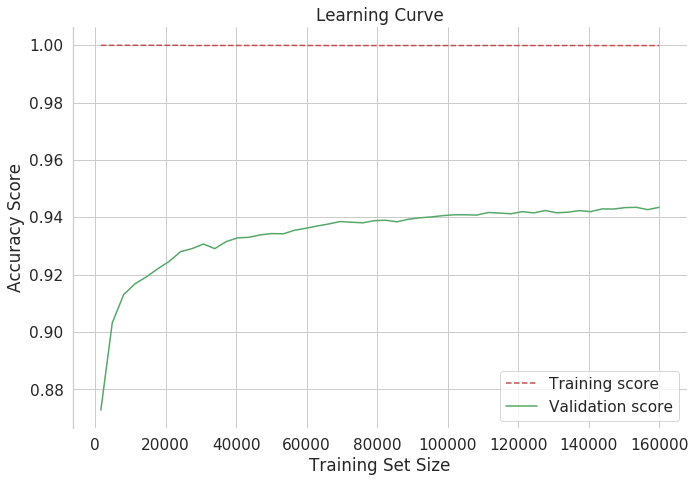

In [14]:
fig = plot_learning_curves(train_sizes, train_scores, test_scores)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/tf-idf/learning_curves.png', dpi=200)

We can see clearly that the training score is still around the maximum and the validation score could be increased with more training samples.

## Error analysis

### Confusion matrix

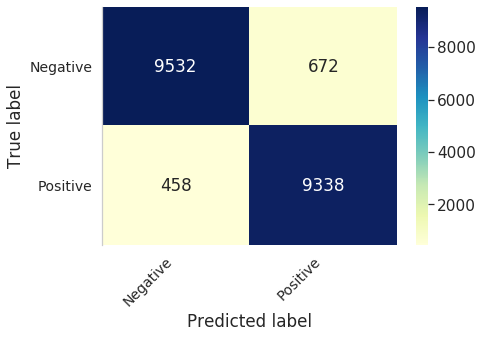

In [10]:
from utils import print_confusion_matrix
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_val, y_pred)

fig = print_confusion_matrix(
    conf_mx, 
    class_names.values(), 
    figsize=(7,5)
)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/tf-idf/val_confusion_mx.png', dpi=200)

### False Positive / Negative

In [11]:
false_pos = X_val[(y_val == 0) & (y_pred == 1)]
false_neg = X_val[(y_val == 1) & (y_pred == 0)]

In [12]:
pd.DataFrame(false_pos[:5])

,0
0,"Drame romanesque,mélodrame rétro,""De l'eau pour les éléphants"" se charge de faire revivre les épopées aux grands sentiments amoureux,aux reconstitutioons luxueux,et au lyrisme assumé.Agréable à l'oeil,valorisé par un casting finalement réussi;le film de Francis lawrence,nous plonge au coeur d'un cirque itinérant,pendant la Grande Dépression.Cette troupe de saltimbanque représentait en quelque sorte le rêve,l'évasion à travers ses numéros grandioses.Immersion réussie dans cet univers très cinématographique,même si le must du genre demeure l'inégalable ""Bronco Billy"" de Clint Eastwood.On est également impressionné par l'éléphante,pivot du récit.Par contre,que le triangle amoureux est niaiseux,prévisble et manichéen.Si Christoph Waltz procure quelques moments électriques en chef de cirque intolérant et jaloux,on ne peut en dire autant de Reese Witherspoon,complètement à côté de ses pompes et de Robert Pattinson,qui en restait à ses 2 expressions tièdes.Et finalement,on se rend qu'il manque l'essentiel:le souffle romanesque,la grâce,l'âme pourrait-on conclure..."
1,"Julie Taymor continue de tracer un sillon particulier.Après les peintures de ""Frida"",elle prend fait et cause pour le mouvement hippie à travers ""Across the universe"".Vous l'aurez compris,nous sommes en plein dans les années 60.L'originalité colorée,c'est qu'il s'agit d'une comédie musicale formée à partir des standards des Beatles,comme ""Let it be""ou ""Strawberry Fields Forever"".Ainsi chaque tableau musical se forme dans une explosion de couleurs vives avec des personnages libres.Des toiles inspirés du pop art de Andy Warhol.Toute la période est retracée,des émeutes de Détroit à Greenwich Village en passant par les docks de Liverpool et la guerre du Vietnam.Taymor est tellement convaincue du pouvoir du ""peace and love"" qu'elle tombe dans la contemplation et le premier degré exagéré.On n'échappe pas aux bons sentiments et au côté très gnan-gnan.De plus,les stéréotypes sur les hippies ne sont qu'accentués(voir notamment l'apparition surprise de Bono).Fatiguant à la longue de baigner dans cet optimisme béat,même si visuellement ce n'est pas désagréable."
2,"Super blonde ou super nul, cest au choix dans les deux cas ce film est une bouse menée de mains de maître par une des actrices les plus mauvaises qu il m ai ete donné de voir, affligent"
3,"Si les institutions morales disent que les films d'horreur, d'action et de SF sont dangereux pour les gosses, elles feraient mieux de se pencher sur ces oeuvres (!?!) pour gosses plus dangereuses que n'importe quel film qu'ils regarderaient en cachette par sa glorification de la bêtise la plus crasse, l'humour le plus débile, la production design la plus laide, et les idéaux développés tout simplement dangereux. Quete de célbrité, vengeance... Laisser les mater les Myasaki, et les pixar ça ce sont des films utiles à un bon développement et à mater en famille"
4,"Après une bande-annonce très rythmée et attractive, un film assez lent et ennuyeux sur la déliquescence d'un jeune couple franco-italien à Jérusalem au moment de la 1ère guerre du Golfe. La tension est donnée effectivement par les missiles irakiens dans le ciel d'Israël. Les 2 moments les plus émouvants ont été pour moi la scène de la mère qui, envers et contre tout, décide de rejoindre sa fille en train d'accoucher seule en pleine nuit et la scène d'une alerte au cours de laquelle la jeune accouchée doit protéger son enfant dans une ""cage"". Sinon c'est simplement la vie ordinaire d'un couple dans une ville extraordinaire et dans des circonstances elles aussi extraordinaires."


In [13]:
pd.DataFrame(false_neg[:5])

,0
0,"Encore un film majeur tres mal distribué, comme par hasard... comme si on voulait nous empecher de comprendre comment on peut se faire gangrener par le mal. Est-ce que vous comprenez ? 4,5/5; cinematographiquement parlant."
1,"""Le film le plus terrifiant de tous les temps"" ? Non du moins plus maintenant, pour une génération qui a grandi avec ""Ring"" ou ""The Grudge"", un lit qui fait nawak' ou un peu de vomi diabolique n'ont plus grand chose d'effrayant. Mais le pilier des films d'épouvante moderne, oui sans aucun doute. Le film n'use d'aucune facilité grossière comme on en voit trop souvent (j'ai tout de même été impressionné par l'absence TOTALE de jumpscare, mes tympans n'en sont que plus heureux) et mise sur un élément primordial pour provoquer le malaise: l'ambiance. Il faudra en effet être patient pour avoir droit aux crises de la petite Raegan, qui n'arrivent qu'après une heure et demi de diagnostics et de problèmes familiaux. D'ici-là il faudra se contenter de quelques rares images subliminales plus intriguantes qu'effrayantes. Cela peut paraître long, mais nécessaire pour installer une atmosphère digne de ce nom. Et même lorsque le mal est fait, le film compte plus sur l'inquiétante étrangeté que l'hémoglobine pour un résultat qui, il faut l'admettre, donne quelques frissons. D'autant qu'hormis un effet un peu cheap lors de la scène de l'escalier, le film n'a visuellement pas pris une ride. Le maquillage est d'une qualité formidable, de même que le jeu d'acteur en particulier concernant la petite Linda Blair, s'imposant à l'époque comme l'une des meilleurs enfants acteurs/actrices. Enfin, le film a le bon goût, malgré les apparences, de ne pas limiter le diable à celui du catholicisme, préférant aller chercher le mal chez les croyances antiques, d'où l'intérêt de la scène d'ouverture dont j'ai mis un temps à saisir le but. Ce serait mentir de dire que les deux heures ne m'en ont paru qu'une seule, l'heure et demi de préparation n'est pas passé comme une lettre à la poste. Mais une fois le ver dans le fruit le résultat n'en est que plus saisissant et cette mise en place n’apparaît plus comme longue mais nécessaire. ""L'Exorciste"" n'a pas usurpé sa réputation de film culte."
2,"Film tout simplement énorme. Enorme pour plusieurs raisons, la première c'est parce qu'on a un véritable personnage devant nous pendant plus de deux heures, ce personnage parle, s'explique. Il est tout simple avec sa coupe de cheveux que ne renierait pas Nicolas Cage, son petit bide, et son gros cigare, fumant sans arrêt. Et puis on a ceux qui l'interviewe. Mal à l'aise, essayant de paraître intelligent, alors qu'ils ne font que se rétamer face à un Godard parfois limite autiste, refusant de comprendre ce qu'on lui dit. Godard s'exprime sur son expo, sur notre musique (qu'il faut voir avant de voir le film sinon il y a bien un quart d'heure où vous serez perdu. Godard parle beaucoup de juifs, je crois qu'il n'a pas abandonné l'idée que les juifs se sont laissés emmené dans les camps comme des moutons (il le dit lui même). Godard n'aime pas le cinéma Hollywoodien, les films avec Bruce Willis Sa vision est assez chaotique, dur de la résumer. à noter que le film n'est pas qu'une longue interview, mais Godard s'exprime sur des sujets différents dans des lieux différents, et dans des temps différents, on sent dans son regard surtout à la fin une sorte de déception sur son expo, sur la vie. Godard aime rire, mais son public semble parfois indifférent à son humour, lui hilare raconte quelque chose et un contre champ montre l'audience limite consternée, c'est assez marrant à voir. Bref je conseillerai de voir ce film pour tout ceux qui ne sont pas allergique à la voix de Godard, et d'en prendre de la graine"
3,"Curieusement, moins d'un quart de siècle après sa sortie, on constate que la plupart des intervenants de Garçon! (1983) ne sont déjà plus parmi nous. A savoir, son réalisateur Claude Sautet, et ses acteurs, Yves Montand, Jacques Villeret

## Save

In [11]:
import pickle

with open('data/tf-idf/best_clf.pickle', 'wb') as f:
    pickle.dump(best_clf, f)

# Testing best model

In [3]:
import pickle

with open('data/tf-idf/best_clf.pickle', 'rb') as f:
    best_clf = pickle.load(f)

In [15]:
from sklearn import metrics 

y_pred = best_clf.predict(X_test)

print("Test Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred)))
print("Test F1-Score: {:.2f}".format(100 * metrics.f1_score(y_test, y_pred)))
print()

report = metrics.classification_report(
    y_test, y_pred, 
    target_names=class_names.values()
)
print(report)

Test Accuracy: 94.38
Test F1-Score: 94.19

              precision    recall  f1-score   support

    Negative       0.95      0.94      0.95     10408
    Positive       0.93      0.95      0.94      9592

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



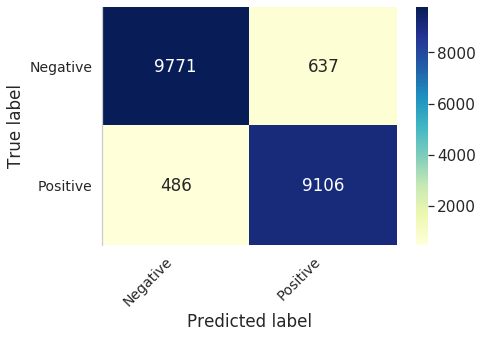

In [17]:
from utils import print_confusion_matrix
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test, y_pred)

fig = print_confusion_matrix(
    conf_mx, 
    class_names.values(), 
    figsize=(7,5)
)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/tf-idf/test_confusion_mx.png', dpi=200)

## Accuracy vs Training data

In [19]:
from sklearn import metrics 

sizes = [1000, 5000, 10000, 20000, 40000, 80000, 120000, 160000]

def accuracy_vs_train_size(model, X_train, y_train, X_test, y_test, sizes):    
    test_accuracies = []
    for size in sizes:
        # Train model on data subset
        model.fit(X_train[:size], y_train[:size])
        y_pred = model.predict(X_test)
        
        # Evaluate on test set
        test_acc = metrics.accuracy_score(y_test, y_pred)
        test_accuracies.append(test_acc)

    return test_accuracies

In [21]:
test_accuracies = accuracy_vs_train_size(
    best_clf, X_train, y_train,
    X_test, y_test, sizes
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   24.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out

In [27]:
import pickle

OUTPUT_PATH = 'data/tf-idf/tfidf_accuracies.pickle'

output_dict = {
    "sizes": sizes,
    "test_accuracies": test_accuracies
}

with open(OUTPUT_PATH, 'wb') as writer:
    pickle.dump(output_dict, writer)

## Inference time

In [ ]:
import pickle

with open('data/tf-idf/best_clf.pickle', 'rb') as f:
    best_clf = pickle.load(f)

In [7]:
import time

inference_times = []

for i in range(1000):
    x = np.array([X_test[i], ])
    start_time = time.time()
    y_pred = best_clf.predict(x)
    stop_time = time.time()
    
    inference_times.append(stop_time - start_time)    

In [8]:
OUTPUT_PATH = 'data/tf-idf/tfidf_times.pickle'

with open(OUTPUT_PATH, 'wb') as writer:
    pickle.dump(inference_times, writer)

## Generalizability

In [32]:
import pickle

with open('data/tf-idf/best_clf.pickle', 'rb') as f:
    best_clf = pickle.load(f)

In [50]:
import os
from utils_acl import get_data

ACL_FOLDER = 'data/cls-acl10-unprocessed/fr'
BOOKS_FOLDER = os.path.join(ACL_FOLDER, 'books')
DVD_FOLDER = os.path.join(ACL_FOLDER, 'dvd')
MUSIC_FOLDER = os.path.join(ACL_FOLDER, 'music')

_, _, X_test_b, y_test_b = get_data(BOOKS_FOLDER)
_, _, X_test_d, y_test_d = get_data(DVD_FOLDER)
_, _, X_test_m, y_test_m = get_data(MUSIC_FOLDER)

> Folder: data/cls-acl10-unprocessed/fr/books
  Len Train: 2000. Len Test: 2000.
> Folder: data/cls-acl10-unprocessed/fr/dvd
  Len Train: 2000. Len Test: 2000.
> Folder: data/cls-acl10-unprocessed/fr/music
  Len Train: 2000. Len Test: 2000.


In [51]:
from sklearn import metrics 

def evaluate(model, X, y):
    y_pred = model.predict(X)
    print("Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y, y_pred)))
    print("F1-Score: {:.2f}".format(100 * metrics.f1_score(y, y_pred)))

### Books

In [52]:
evaluate(best_clf, X_test_b, y_test_b)

Accuracy: 87.10
F1-Score: 87.40


### DVD

In [53]:
evaluate(best_clf, X_test_d, y_test_d)

Accuracy: 88.10
F1-Score: 88.59


### Music

In [54]:
evaluate(best_clf, X_test_m, y_test_m)

Accuracy: 87.45
F1-Score: 88.14
